<a href="https://colab.research.google.com/github/Rhqo/Toy-Models-of-Superposition/blob/main/KBH_Toy_Models_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# My_Toy_Models
Class 정의, 모델 정의, 함수 정의 등 논문에 있는 코드 활용

In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from typing import Optional
import numpy as np
from tqdm import trange
import time
import einops
import matplotlib.pyplot as plt
import math

In [2]:
# 디바이스 체크
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

class Config:
    def __init__(self, n_features: int, n_hidden: int, n_instances: int):
        self.n_features = n_features
        self.n_hidden = n_hidden
        self.n_instances = n_instances

class Model(nn.Module):
    def __init__(self,
                config,
                activation=True,
                feature_probability: Optional[torch.Tensor] = None,
                importance: Optional[torch.Tensor] = None,
                device='cuda'):
        super().__init__()
        self.config = config
        self.activation = activation
        self.W = nn.Parameter(torch.empty((config.n_instances, config.n_features, config.n_hidden), device=device))
        nn.init.xavier_normal_(self.W)
        self.b_final = nn.Parameter(torch.zeros((config.n_instances, config.n_features), device=device))

        if feature_probability is None:
            feature_probability = torch.ones(())
        self.feature_probability = feature_probability.to(device)
        if importance is None:
            importance = torch.ones(())
        self.importance = importance.to(device)

    def forward(self, features):
        # features: [..., instance, n_features]
        # W: [instance, n_features, n_hidden]
        hidden = torch.einsum("...if,ifh->...ih", features, self.W)
        out = torch.einsum("...ih,ifh->...if", hidden, self.W)
        out = out + self.b_final
        if self.activation:
            out = F.relu(out)
        return out

    def hidden(self, features):
        hidden = torch.einsum("...if,ifh->...ih", features, self.W)
        return hidden

    def generate_batch(self, n_batch):
        feat = torch.rand((n_batch, self.config.n_instances, self.config.n_features), device=self.W.device)
        prob_matrix = self.feature_probability.unsqueeze(0).expand(n_batch, -1, -1)
        batch = torch.where(
            torch.rand((n_batch, self.config.n_instances, self.config.n_features), device=self.W.device) <= prob_matrix,
            feat,
            torch.zeros((n_batch, self.config.n_instances, self.config.n_features), device=self.W.device),
        )
        return batch

def linear_lr(step, steps):
  return (1 - (step / steps))

def constant_lr(*_):
  return 1.0

def cosine_decay_lr(step, steps):
  return np.cos(0.5 * np.pi * step / (steps - 1))

def optimize(model,
             render=False,
             n_batch=1024,
             steps=10_000,
             print_freq=100,
             lr=1e-3,
             lr_scale=constant_lr,
             hooks=[]):
  cfg = model.config

  opt = torch.optim.AdamW(list(model.parameters()), lr=lr)

  start = time.time()
  with trange(steps) as t:
    for step in t:
      step_lr = lr * lr_scale(step, steps)
      for group in opt.param_groups:
        group['lr'] = step_lr
      opt.zero_grad(set_to_none=True)
      batch = model.generate_batch(n_batch)
      out = model(batch)
      error = (model.importance*(batch.abs() - out)**2)
      loss = einops.reduce(error, 'b i f -> i', 'mean').sum()
      loss.backward()
      opt.step()

      if hooks:
        hook_data = dict(model=model,
                         step=step,
                         opt=opt,
                         error=error,
                         loss=loss,
                         lr=step_lr)
        for h in hooks:
          h(hook_data)
      if step % print_freq == 0 or (step + 1 == steps):
        t.set_postfix(
            loss=loss.item() / cfg.n_instances,
            lr=step_lr,
        )

## Non-Uniform Superposition 분포 확인
$n = 3$ \
$m = 2$ \
$I_i = 1$ \
$I-S = 0.05$ (baseline) \

다른 모든 요소는 일정 한 채로, 특정 한 차원의 sparsity만 조정했을 때의 데이터 분포 변화

In [3]:
config = Config(
    n_features = 3,
    n_hidden = 2,
    n_instances = 9,
)

#density가 0.005에서 0.5까지 일정하게 증가하도록
sparsity = torch.tensor([
    [1 - 10**(math.log10(0.005) + i * (math.log10(0.5) - math.log10(0.005)) / (config.n_instances - 1)), 0.95, 0.95] for i in range(config.n_instances)
], device=DEVICE)

model = Model(
    config=config,
    device=DEVICE,
    # Exponential feature importance curve from 1 to 1/100
    importance = (torch.ones(config.n_features))[None, :],
    # Sweep feature frequency across the instances from 1 (fully dense) to 1/20
    feature_probability = 1 - sparsity
)

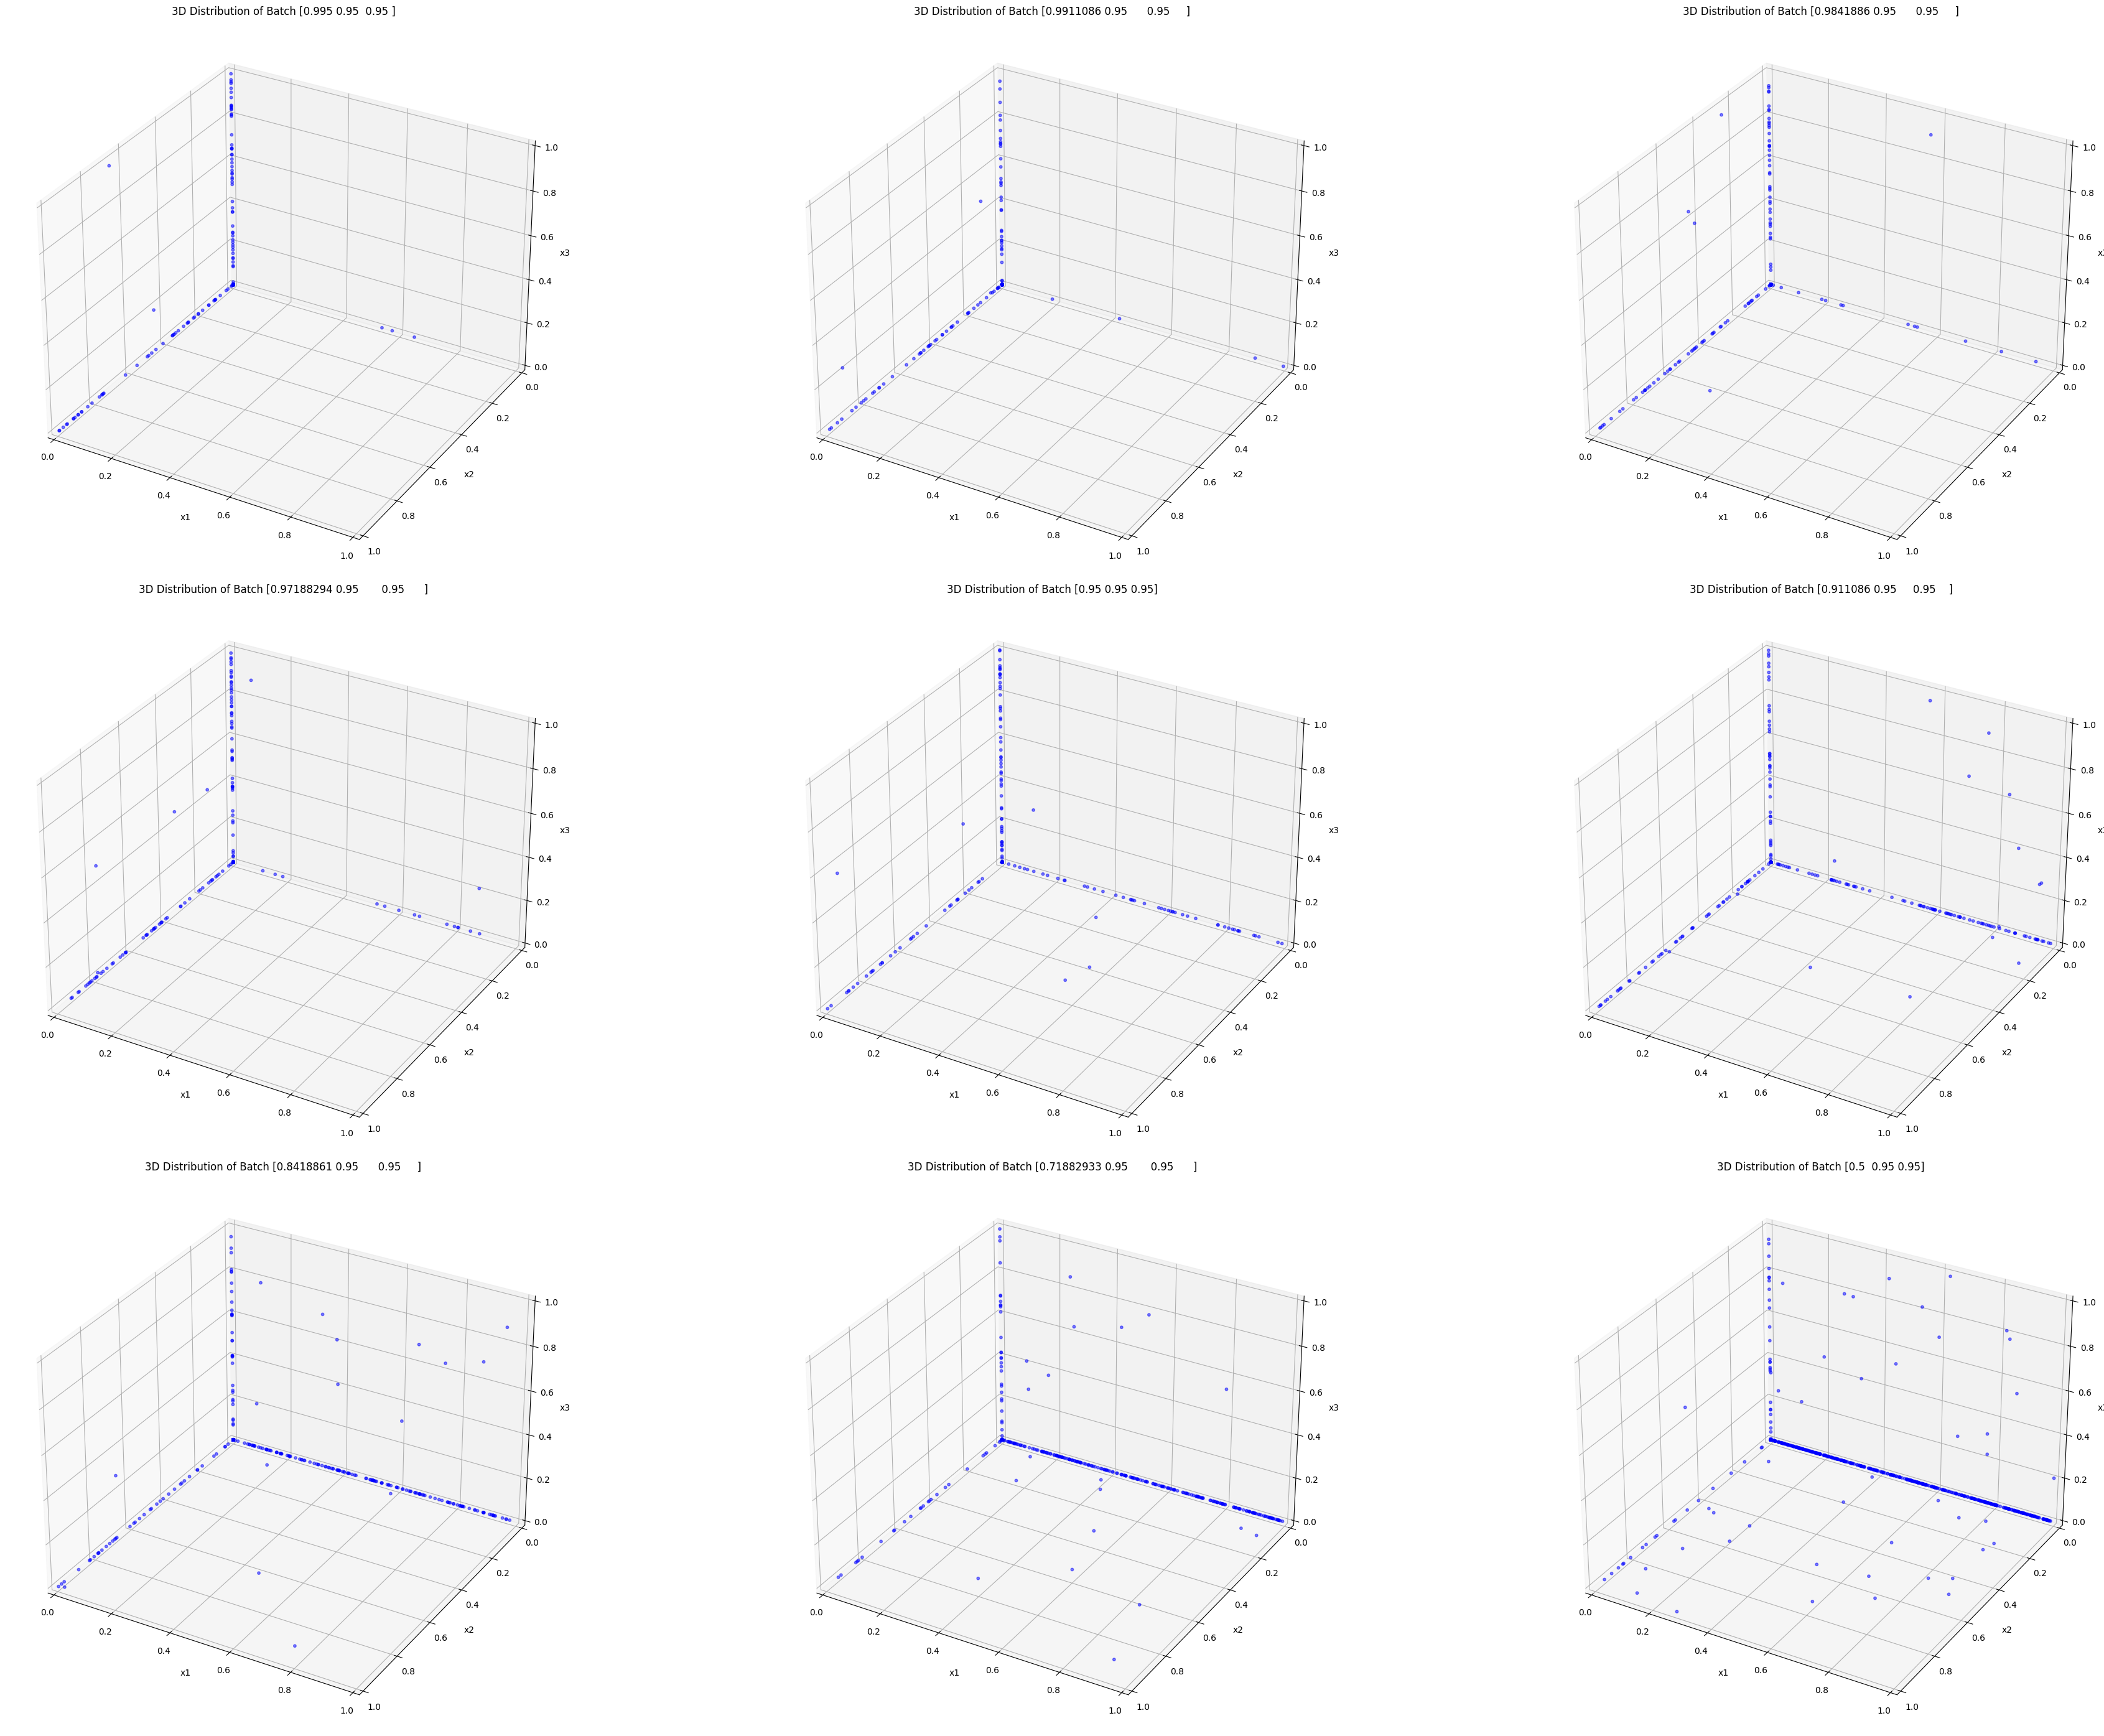

In [4]:
# Plotting the 3D distribution of x
x = model.generate_batch(1000)
x = x.permute(1, 0, 2)


x_distribute = x.cpu().numpy()
fig = plt.figure(figsize=(40, 28))

for i in range(config.n_instances):
    ax = fig.add_subplot(3, 3, i+1, projection='3d')
    x_distribute = x[i].cpu().numpy()
    ax.scatter(x_distribute[:, 0], x_distribute[:, 1], x_distribute[:, 2], alpha=0.5, s=10, c='b')

    # Setting labels
    ax.set_title(f'3D Distribution of Batch {sparsity.cpu().numpy()[i]}', fontsize=12)
    ax.set_xlim3d(0, 1)
    ax.set_ylim3d(1, 0)
    ax.set_zlim3d(0, 1)
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_zlabel('x3')

plt.tight_layout()
plt.show()

# Non-Uniform Superposition
지금까지는 모든 특징이 동일한 중요성과 희소성, 독립성을 가지는 uniform superposition의 기하학에 초점을 맞추어 왔다. \

하지만, 실제로 feature들이 모두 균일할 것이라는 보장이 없으므로, \
feature들이 어떤 식으로든 균일하지 않은 non-uniform superposition에 대해 알아보는 것이 필요하다.

## Perturbing a single feature

$n = 5$ \
$m = 2$ \
$I_i = 1$ \
$I-S = 0.05$ (baseline) \
특정 feature의 sparsity만 조정했을 때의 위상 변화 \

sparsity가 감소 하면, 해당 feature가 0이 될 확률이 감소 -> 해당 feature의 상대적인 중요도 증가함을 확인

In [24]:
config = Config(
    n_features = 5,
    n_hidden = 2,
    n_instances = 21,
)

sparsity = torch.tensor([
    [1 - 10**(math.log10(0.005) + i * (math.log10(0.5) - math.log10(0.005)) / (config.n_instances - 1)), 0.95, 0.95, 0.95, 0.95] for i in range(config.n_instances)
], device=DEVICE)

model = Model(
    config=config,
    device=DEVICE,
    # Exponential feature importance curve from 1 to 1/100
    importance = (torch.ones(config.n_features))[None, :],
    # Sweep feature frequency across the instances from 1 (fully dense) to 1/20
    feature_probability = 1 - sparsity
)
sparsity

tensor([[0.9950, 0.9500, 0.9500, 0.9500, 0.9500],
        [0.9937, 0.9500, 0.9500, 0.9500, 0.9500],
        [0.9921, 0.9500, 0.9500, 0.9500, 0.9500],
        [0.9900, 0.9500, 0.9500, 0.9500, 0.9500],
        [0.9874, 0.9500, 0.9500, 0.9500, 0.9500],
        [0.9842, 0.9500, 0.9500, 0.9500, 0.9500],
        [0.9801, 0.9500, 0.9500, 0.9500, 0.9500],
        [0.9749, 0.9500, 0.9500, 0.9500, 0.9500],
        [0.9685, 0.9500, 0.9500, 0.9500, 0.9500],
        [0.9603, 0.9500, 0.9500, 0.9500, 0.9500],
        [0.9500, 0.9500, 0.9500, 0.9500, 0.9500],
        [0.9371, 0.9500, 0.9500, 0.9500, 0.9500],
        [0.9208, 0.9500, 0.9500, 0.9500, 0.9500],
        [0.9002, 0.9500, 0.9500, 0.9500, 0.9500],
        [0.8744, 0.9500, 0.9500, 0.9500, 0.9500],
        [0.8419, 0.9500, 0.9500, 0.9500, 0.9500],
        [0.8009, 0.9500, 0.9500, 0.9500, 0.9500],
        [0.7494, 0.9500, 0.9500, 0.9500, 0.9500],
        [0.6845, 0.9500, 0.9500, 0.9500, 0.9500],
        [0.6028, 0.9500, 0.9500, 0.9500, 0.9500],


In [25]:
optimize(model)

100%|██████████| 10000/10000 [00:04<00:00, 2052.64it/s, loss=0.00238, lr=0.001]


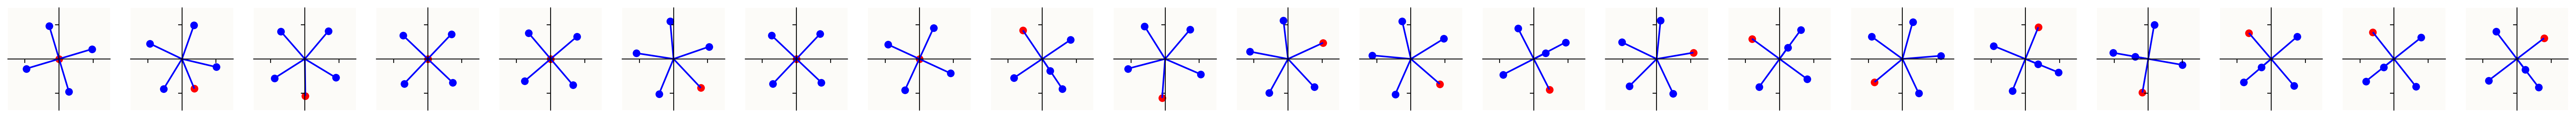

In [26]:
from matplotlib import colors  as mcolors
from matplotlib import collections  as mc

cfg = model.config
WA = model.W.detach()
N = len(WA[:,0])
sel = range(config.n_instances)  # can be used to highlight specific sparsity levels

plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.viridis(model.importance[0].cpu().numpy()))
plt.rcParams['figure.dpi'] = 200
fig, axs = plt.subplots(1, len(sel), figsize=(2 * len(sel), 2))

for i, ax in zip(sel, axs):
    W = WA[i].cpu().detach().numpy()

    # Highlight the first vector with a different color
    ax.scatter(W[0, 0], W[0, 1], c='red', label='First Vector')  # Highlight the first vector

    # Scatter the rest of the points with the default colors
    ax.scatter(W[1:, 0], W[1:, 1], c='blue')  # Scatter the rest with default color

    ax.set_aspect('equal')
    ax.add_collection(mc.LineCollection(np.stack((np.zeros_like(W), W), axis=1), colors='blue'))

    z = 1.5
    ax.set_facecolor('#FCFBF8')
    ax.set_xlim((-z, z))
    ax.set_ylim((-z, z))
    ax.tick_params(left=True, right=False, labelleft=False, labelbottom=False, bottom=True)

    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)
    for spine in ['bottom', 'left']:
        ax.spines[spine].set_position('center')

plt.show()


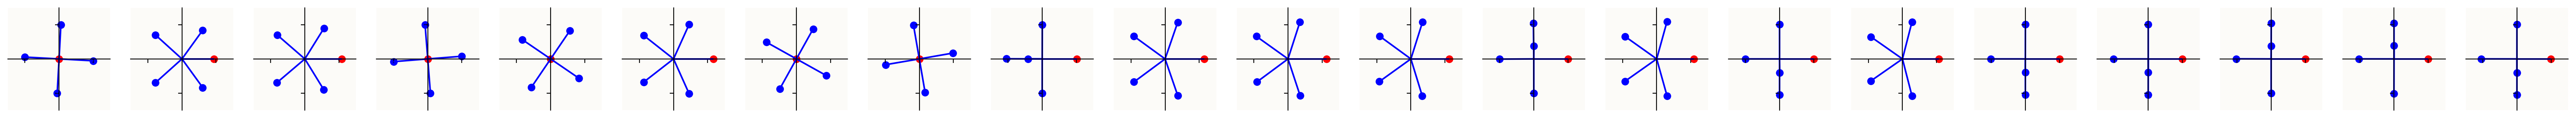

In [27]:
import numpy as np
from matplotlib import colors as mcolors
from matplotlib import collections as mc

cfg = model.config
WA = model.W.detach()
N = len(WA[:, 0])
sel = range(config.n_instances)  # can be used to highlight specific sparsity levels

plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.viridis(model.importance[0].cpu().numpy()))
plt.rcParams['figure.dpi'] = 200
fig, axs = plt.subplots(1, len(sel), figsize=(2 * len(sel), 2))

for i, ax in zip(sel, axs):
    W = WA[i].cpu().detach().numpy()

    # 첫 번째 벡터를 (x1, y1)으로 설정
    first_vector = W[0]

    # 첫 번째 벡터와 x축 사이의 각도 계산
    angle = np.arctan2(first_vector[1], first_vector[0])

    # 회전 행렬 (각도 angle에 의해 회전)
    rotation_matrix = np.array([
        [np.cos(-angle), -np.sin(-angle)],
        [np.sin(-angle), np.cos(-angle)]
    ])

    # 모든 벡터에 회전 행렬을 적용
    rotated_vectors = np.dot(W, rotation_matrix.T)

    # 회전된 벡터들을 그리기
    ax.scatter(rotated_vectors[0, 0], rotated_vectors[0, 1], c='red', label='First Vector')  # 첫 번째 벡터
    ax.scatter(rotated_vectors[1:, 0], rotated_vectors[1:, 1], c='blue')  # 나머지 벡터들

    ax.set_aspect('equal')
    ax.add_collection(mc.LineCollection(np.stack((np.zeros_like(rotated_vectors), rotated_vectors), axis=1), colors='blue'))

    z = 1.5
    ax.set_facecolor('#FCFBF8')
    ax.set_xlim((-z, z))
    ax.set_ylim((-z, z))
    ax.tick_params(left=True, right=False, labelleft=False, labelbottom=False, bottom=True)

    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)
    for spine in ['bottom', 'left']:
        ax.spines[spine].set_position('center')

plt.show()


## Correlated and Anticorrelated Features

Feature끼리의 상관관계 혹은 비상관관계가 존재할 경우의 위상 변화



### Correlated and Anticorrelated features 분포 확인
